In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
import os
import sys
import pathlib
import pickle
import warnings

sys.path.append('../..')

In [4]:
import pandas as pd
from loguru import logger
import seaborn as sns

In [5]:
from pals.pimp_tools import get_pimp_API_token_from_env, PIMP_HOST, download_from_pimp
from pals.noise import construct_intensity_df, add_random_peaks, plot_intensity_matrix, convert_to_data_source
from pals.evaluation import run_noise_experiment, calc_av_p_scores, construct_single_box_df, _compute_prec_rec_f1, _select_significant_entries, get_tp_fn_fn, adjust_box_widths, get_auc_for_noise
from pals.feature_extraction import DataSource

from pals.PLAGE import PLAGE
from pals.ORA import ORA
from pals.GSEA import GSEA
from pals.common import *

2021-09-13 16:14:33.915 | WARNING  | pals.reactome:get_neo4j_driver:14 - Using a default neo4j server: bolt://localhost:7687
2021-09-13 16:14:33.916 | WARNING  | pals.reactome:get_neo4j_driver:19 - Using a default neo4j username or password: neo4j
2021-09-13 16:14:36.020 | INFO     | pals.reactome:get_neo4j_driver:24 - Created graph database driver for bolt://localhost:7687 (neo4j)


## Synthetic data test

In [6]:
control_fnames = ['Control_1.mzXML', 'Control_2.mzXML', 'Control_3.mzXML', 'Control_4.mzXML']
case_fnames = ['Case_1.mzXML', 'Case_2.mzXML', 'Case_3.mzXML', 'Case_4.mzXML']
pathway_names ={'two':2, 'four':4, 'six':6, 'ten':10, 'twenty':20, 'forty':40, 'eighty':80}
sample_fnames = control_fnames + case_fnames
true_answers = set(pathway_names.keys())

num_iterations = 500
bg_pw = 100
gsea_resamples = 1000
gsea_ranking_method = GSEA_RANKING_SNR
min_replace = 5000
plage_weight = 1
hg_weight = 0
prob_missing_peaks = 0.2
parallel = True

base_dir = os.path.join('..', 'test_data', 'synthetic')
create_if_not_exist(base_dir)

Try generating some synthetic data without noise

(2763, 8)
{'two': 2, 'four': 4, 'six': 6, 'ten': 10, 'twenty': 20, 'forty': 40, 'eighty': 80, 'background0': 13, 'background1': 14, 'background2': 35, 'background3': 8, 'background4': 43, 'background5': 41, 'background6': 21, 'background7': 20, 'background8': 26, 'background9': 13, 'background10': 8, 'background11': 35, 'background12': 28, 'background13': 11, 'background14': 42, 'background15': 23, 'background16': 22, 'background17': 31, 'background18': 5, 'background19': 47, 'background20': 35, 'background21': 7, 'background22': 37, 'background23': 8, 'background24': 21, 'background25': 22, 'background26': 30, 'background27': 19, 'background28': 20, 'background29': 29, 'background30': 8, 'background31': 33, 'background32': 30, 'background33': 40, 'background34': 23, 'background35': 26, 'background36': 12, 'background37': 19, 'background38': 47, 'background39': 28, 'background40': 31, 'background41': 49, 'background42': 11, 'background43': 34, 'background44': 8, 'background45': 32, 'ba

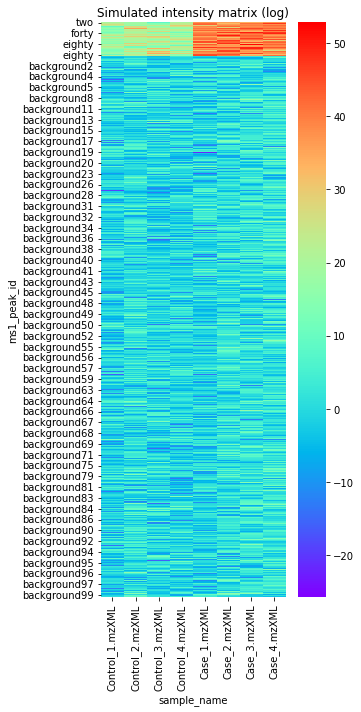

In [7]:
int_df, updated_pathway_names = construct_intensity_df(sample_fnames, pathway_names, random=False, background_pathways=bg_pw)
print(int_df.shape)
print(updated_pathway_names)

out_file = os.path.join(base_dir, 'simulated_intensity.eps')
plot_intensity_matrix(int_df, out_file=out_file)

Convert simulated data above to a PALS DataSource object and run pathway analysis

In [8]:
ds = convert_to_data_source(int_df, updated_pathway_names, case_fnames, control_fnames, prob_missing_peaks, min_replace)

2021-09-13 16:14:40.764 | DEBUG    | pals.noise:convert_to_data_source:111 - Dataset annotations = 2763
2021-09-13 16:14:40.764 | DEBUG    | pals.noise:convert_to_data_source:115 - Sampled annotations = 2763 with prob_missing_peaks=0.20
2021-09-13 16:14:40.765 | DEBUG    | pals.feature_extraction:__init__:48 - Using user-provided database
2021-09-13 16:14:40.766 | DEBUG    | pals.feature_extraction:__init__:68 - Mapping pathway to unique ids
2021-09-13 16:14:40.769 | DEBUG    | pals.feature_extraction:__init__:82 - Creating dataset to pathway mapping
2021-09-13 16:14:40.929 | DEBUG    | pals.feature_extraction:__init__:110 - Computing unique id counts
2021-09-13 16:14:40.936 | DEBUG    | pals.feature_extraction:__init__:48 - Using user-provided database
2021-09-13 16:14:40.937 | DEBUG    | pals.feature_extraction:__init__:68 - Mapping pathway to unique ids
2021-09-13 16:14:40.941 | DEBUG    | pals.feature_extraction:__init__:82 - Creating dataset to pathway mapping
2021-09-13 16:14:41.

In [9]:
pals = PLAGE(ds, plage_weight=plage_weight, hg_weight=hg_weight)
pals_df = pals.get_results()
pals_df.sort_values('pw_name')

2021-09-13 16:14:41.223 | DEBUG    | pals.PLAGE:__init__:31 - PLAGE initialised
2021-09-13 16:14:41.284 | DEBUG    | pals.preprocessing:process:17 - Replacing negative and zero values with NaN
2021-09-13 16:14:41.288 | DEBUG    | pals.preprocessing:process:29 - Performing min-value imputation
2021-09-13 16:14:41.293 | DEBUG    | pals.preprocessing:process:42 - Performing row average imputation
2021-09-13 16:14:41.302 | DEBUG    | pals.preprocessing:process:70 - Applying log normalisation
2021-09-13 16:14:41.303 | DEBUG    | pals.preprocessing:process:77 - Scaling the data across the sample: zero mean and unit variance
2021-09-13 16:14:41.348 | DEBUG    | pals.PLAGE:get_plage_activity_df:87 - Mean values of the rows in the DF is [-0. -0. -0. ... -0. -0.  0.]
2021-09-13 16:14:41.349 | DEBUG    | pals.PLAGE:get_plage_activity_df:88 - Variance in the rows of the DF is [1. 1. 1. ... 1. 1. 1.]
2021-09-13 16:14:41.410 | DEBUG    | pals.PLAGE:set_up_resample_plage_p_df:99 - Calculating plage p

,pw_name,case/control p-value,unq_pw_F,tot_ds_F,F_coverage,sf,exp_F,Ex_Cov,case/control comb_p
background0,background0,1.000000,13,11,84.62,0.500850,10.40,80.00,1.000000
background1,background1,1.000000,14,12,85.71,0.447098,11.20,80.00,1.000000
background10,background10,0.998066,8,7,87.50,0.502678,6.40,80.00,0.998066
background11,background11,1.000000,35,32,91.43,0.059145,27.99,79.97,1.000000
background12,background12,1.000000,28,22,78.57,0.678268,22.40,80.00,1.000000
...,...,...,...,...,...,...,...,...,...
four,four,0.020156,4,4,100.00,0.409081,3.20,80.00,0.020156
six,six,0.009273,6,6,100.00,0.261503,4.80,80.00,0.009273
ten,ten,0.006296,10,6,60.00,0.967374,8.00,80.00,0.006296
twenty,twenty,0.001799,20,17,85.00,0.410181,16.00,80.00,0.001799


In [10]:
ora = ORA(ds)
ora_df = ora.get_results(correct_multiple_tests=True)
ora_df.sort_values('pw_name')

2021-09-13 16:14:43.551 | DEBUG    | pals.ORA:__init__:21 - ORA initialised
2021-09-13 16:14:43.623 | DEBUG    | pals.ORA:get_results:47 - Calculating ORA
2021-09-13 16:14:43.624 | DEBUG    | pals.preprocessing:process:17 - Replacing negative and zero values with NaN
2021-09-13 16:14:43.628 | DEBUG    | pals.preprocessing:process:29 - Performing min-value imputation
2021-09-13 16:14:43.633 | DEBUG    | pals.preprocessing:process:42 - Performing row average imputation
2021-09-13 16:14:43.643 | DEBUG    | pals.preprocessing:process:70 - Applying log normalisation
2021-09-13 16:14:44.356 | DEBUG    | pals.ORA:get_results:104 - Correcting for multiple t-tests
2021-09-13 16:14:44.360 | DEBUG    | pals.feature_extraction:_calculate_coverage_df:341 - Calculating dataset formula coverage


,pw_name,case/control p-value,case/control comb_p,unq_pw_F,tot_ds_F,F_coverage
background0,background0,1.000000e+00,1.000000e+00,13,11,84.62
background1,background1,1.000000e+00,1.000000e+00,14,12,85.71
background10,background10,1.000000e+00,1.000000e+00,8,7,87.50
background11,background11,9.660579e-01,1.000000e+00,35,32,91.43
background12,background12,9.329855e-01,1.000000e+00,28,22,78.57
...,...,...,...,...,...,...
four,four,6.879466e-05,1.472206e-03,4,4,100.00
six,six,5.582899e-07,1.493426e-05,6,6,100.00
ten,ten,8.522953e-05,1.519927e-03,10,6,60.00
twenty,twenty,1.199211e-15,4.277188e-14,20,17,85.00


In [11]:
gsea = GSEA(ds, num_resamples=gsea_resamples, method=gsea_ranking_method)
gsea_df = gsea.get_results()
gsea_df.sort_values('pw_name')

2021-09-13 16:14:44.514 | DEBUG    | pals.GSEA:__init__:39 - GSEA initialised with num_resamples=1000 and ranking_method=signal_to_noise
2021-09-13 16:14:44.567 | DEBUG    | pals.GSEA:get_results:65 - Calculating GSEA
2021-09-13 16:14:44.568 | DEBUG    | pals.preprocessing:process:17 - Replacing negative and zero values with NaN
2021-09-13 16:14:44.572 | DEBUG    | pals.preprocessing:process:29 - Performing min-value imputation
2021-09-13 16:14:44.577 | DEBUG    | pals.preprocessing:process:42 - Performing row average imputation
2021-09-13 16:14:44.594 | DEBUG    | pals.GSEA:get_results:94 - Running comparison case=case control=control
2021-09-13 16:14:53.739 | DEBUG    | pals.feature_extraction:_calculate_coverage_df:341 - Calculating dataset formula coverage


,pw_name,case/control p-value,case/control comb_p,case/control ES_score,unq_pw_F,tot_ds_F,F_coverage
background0,background0,0.098039,0.815708,-0.435704,13,11,84.62
background1,background1,0.857143,1.000000,-0.188519,14,12,85.71
background10,background10,0.777778,1.000000,-0.304915,8,7,87.50
background11,background11,0.650000,0.939064,0.208823,35,32,91.43
background12,background12,0.120690,0.479246,0.268744,28,22,78.57
...,...,...,...,...,...,...,...
four,four,0.053571,0.067270,0.746600,4,4,100.00
six,six,0.054545,0.037098,0.726860,6,6,100.00
ten,ten,0.053571,0.335692,0.707804,10,6,60.00
twenty,twenty,0.053571,0.029678,0.690378,20,17,85.00


Now take the synthetic data matrix above, add some noisy peaks (100%) and run pathway analysis methods again.

(3168, 8)


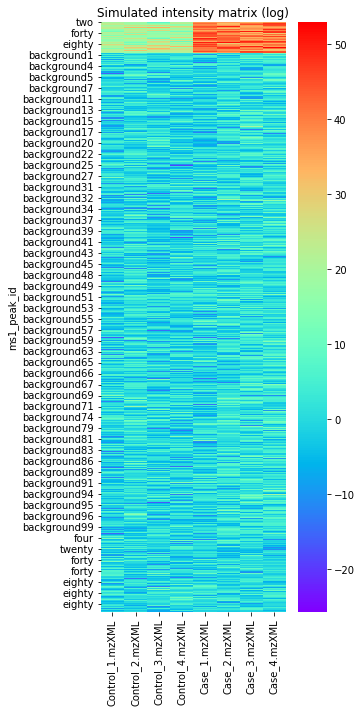

In [12]:
percent = 250
noise_mean = 0
noise_std = 5
int_df = add_random_peaks(sample_fnames, pathway_names, int_df, percent, noise_mean, noise_std)
print(int_df.shape)
plot_intensity_matrix(int_df)

In [13]:
ds = convert_to_data_source(int_df, updated_pathway_names, case_fnames, control_fnames, prob_missing_peaks, min_replace)

2021-09-13 16:14:55.881 | DEBUG    | pals.noise:convert_to_data_source:111 - Dataset annotations = 3168
2021-09-13 16:14:55.882 | DEBUG    | pals.noise:convert_to_data_source:115 - Sampled annotations = 3168 with prob_missing_peaks=0.20
2021-09-13 16:14:55.883 | DEBUG    | pals.feature_extraction:__init__:48 - Using user-provided database
2021-09-13 16:14:55.884 | DEBUG    | pals.feature_extraction:__init__:68 - Mapping pathway to unique ids
2021-09-13 16:14:55.886 | DEBUG    | pals.feature_extraction:__init__:82 - Creating dataset to pathway mapping
2021-09-13 16:14:56.149 | DEBUG    | pals.feature_extraction:__init__:110 - Computing unique id counts
2021-09-13 16:14:56.158 | DEBUG    | pals.feature_extraction:__init__:48 - Using user-provided database
2021-09-13 16:14:56.159 | DEBUG    | pals.feature_extraction:__init__:68 - Mapping pathway to unique ids
2021-09-13 16:14:56.163 | DEBUG    | pals.feature_extraction:__init__:82 - Creating dataset to pathway mapping
2021-09-13 16:14:56.

In [14]:
pals = PLAGE(ds, plage_weight=plage_weight, hg_weight=hg_weight)
pals_df = pals.get_results()
pals_df.sort_values('pw_name')

2021-09-13 16:14:56.645 | DEBUG    | pals.PLAGE:__init__:31 - PLAGE initialised
2021-09-13 16:14:56.727 | DEBUG    | pals.preprocessing:process:17 - Replacing negative and zero values with NaN
2021-09-13 16:14:56.732 | DEBUG    | pals.preprocessing:process:29 - Performing min-value imputation
2021-09-13 16:14:56.739 | DEBUG    | pals.preprocessing:process:42 - Performing row average imputation
2021-09-13 16:14:56.749 | DEBUG    | pals.preprocessing:process:70 - Applying log normalisation
2021-09-13 16:14:56.751 | DEBUG    | pals.preprocessing:process:77 - Scaling the data across the sample: zero mean and unit variance
2021-09-13 16:14:56.801 | DEBUG    | pals.PLAGE:get_plage_activity_df:87 - Mean values of the rows in the DF is [ 0. -0.  0. ... -0.  0.  0.]
2021-09-13 16:14:56.803 | DEBUG    | pals.PLAGE:get_plage_activity_df:88 - Variance in the rows of the DF is [1. 1. 1. ... 1. 1. 1.]
2021-09-13 16:14:56.874 | DEBUG    | pals.PLAGE:set_up_resample_plage_p_df:99 - Calculating plage p

,pw_name,case/control p-value,unq_pw_F,tot_ds_F,F_coverage,sf,exp_F,Ex_Cov,case/control comb_p
background0,background0,1.000000,13,10,76.92,0.747228,10.40,80.00,1.000000
background1,background1,1.000000,14,8,57.14,0.988522,11.20,80.00,1.000000
background10,background10,1.000000,8,6,75.00,0.796848,6.40,80.00,1.000000
background11,background11,1.000000,35,26,74.29,0.855064,28.00,80.00,1.000000
background12,background12,1.000000,28,20,71.43,0.910621,22.40,80.00,1.000000
...,...,...,...,...,...,...,...,...,...
four,four,0.221081,14,12,85.71,0.447220,11.20,80.00,0.221081
six,six,0.001022,21,18,85.71,0.369147,16.80,80.00,0.001022
ten,ten,0.029200,35,32,91.43,0.059321,28.00,80.00,0.029200
twenty,twenty,0.037094,70,58,82.86,0.332886,55.99,79.99,0.037094


In [15]:
ora = ORA(ds)
ora_df = ora.get_results(correct_multiple_tests=True)
ora_df.sort_values('pw_name')

2021-09-13 16:14:58.916 | DEBUG    | pals.ORA:__init__:21 - ORA initialised
2021-09-13 16:14:58.995 | DEBUG    | pals.ORA:get_results:47 - Calculating ORA
2021-09-13 16:14:58.996 | DEBUG    | pals.preprocessing:process:17 - Replacing negative and zero values with NaN
2021-09-13 16:14:59.000 | DEBUG    | pals.preprocessing:process:29 - Performing min-value imputation
2021-09-13 16:14:59.007 | DEBUG    | pals.preprocessing:process:42 - Performing row average imputation
2021-09-13 16:14:59.016 | DEBUG    | pals.preprocessing:process:70 - Applying log normalisation
2021-09-13 16:14:59.937 | DEBUG    | pals.ORA:get_results:104 - Correcting for multiple t-tests
2021-09-13 16:14:59.942 | DEBUG    | pals.feature_extraction:_calculate_coverage_df:341 - Calculating dataset formula coverage


,pw_name,case/control p-value,case/control comb_p,unq_pw_F,tot_ds_F,F_coverage
background0,background0,1.000000,1.000000,13,10,76.92
background1,background1,1.000000,1.000000,14,8,57.14
background10,background10,1.000000,1.000000,8,6,75.00
background11,background11,0.954905,1.000000,35,26,74.29
background12,background12,0.915947,1.000000,28,20,71.43
...,...,...,...,...,...,...
four,four,0.025088,0.447398,14,12,85.71
six,six,0.000177,0.003781,21,18,85.71
ten,ten,0.000083,0.002216,35,32,91.43
twenty,twenty,0.000043,0.001534,70,58,82.86


In [16]:
gsea = GSEA(ds, num_resamples=gsea_resamples, method=gsea_ranking_method)
gsea_df = gsea.get_results()
gsea_df.sort_values('pw_name')

2021-09-13 16:15:00.215 | DEBUG    | pals.GSEA:__init__:39 - GSEA initialised with num_resamples=1000 and ranking_method=signal_to_noise
2021-09-13 16:15:00.305 | DEBUG    | pals.GSEA:get_results:65 - Calculating GSEA
2021-09-13 16:15:00.307 | DEBUG    | pals.preprocessing:process:17 - Replacing negative and zero values with NaN
2021-09-13 16:15:00.312 | DEBUG    | pals.preprocessing:process:29 - Performing min-value imputation
2021-09-13 16:15:00.320 | DEBUG    | pals.preprocessing:process:42 - Performing row average imputation
2021-09-13 16:15:00.348 | DEBUG    | pals.GSEA:get_results:94 - Running comparison case=case control=control
2021-09-13 16:15:09.493 | DEBUG    | pals.feature_extraction:_calculate_coverage_df:341 - Calculating dataset formula coverage


,pw_name,case/control p-value,case/control comb_p,case/control ES_score,unq_pw_F,tot_ds_F,F_coverage
background0,background0,0.090909,0.198895,-0.468829,13,10,76.92
background1,background1,0.421053,1.000000,0.380938,14,8,57.14
background10,background10,0.894737,0.993310,0.259877,8,6,75.00
background11,background11,0.627451,1.000000,0.212823,35,26,74.29
background12,background12,0.687500,0.953626,0.219585,28,20,71.43
...,...,...,...,...,...,...,...
four,four,0.754098,0.981595,0.279764,14,12,85.71
six,six,0.050847,0.653211,0.316866,21,18,85.71
ten,ten,0.188679,0.547065,0.310955,35,32,91.43
twenty,twenty,0.269841,1.000000,0.224296,70,58,82.86


### Experiments

### Experiment 1: adding noise

In [ ]:
prob_missing_peaks = 0.20
noise_std = 5
reqd_scenarios = [
    { 'noise_std': noise_std, 'percent': 0, 'prob_missing_peaks': prob_missing_peaks, },
    { 'noise_std': noise_std, 'percent': 25, 'prob_missing_peaks': prob_missing_peaks, },
    { 'noise_std': noise_std, 'percent': 50, 'prob_missing_peaks': prob_missing_peaks, },
    { 'noise_std': noise_std, 'percent': 100, 'prob_missing_peaks': prob_missing_peaks, },        
    { 'noise_std': noise_std, 'percent': 250, 'prob_missing_peaks': prob_missing_peaks, },
    { 'noise_std': noise_std, 'percent': 500, 'prob_missing_peaks': prob_missing_peaks, },
    { 'noise_std': noise_std, 'percent': 1000, 'prob_missing_peaks': prob_missing_peaks, },
]

#### Run experiment

In this experiment, we add some % of noise to the data, and compares how the different methods perform.

In [ ]:
out_file = os.path.join(base_dir, 'experiment_1.p')

In [ ]:
pals_df, ora_df, gsea_df, exp_results = run_noise_experiment(bg_pw, case_fnames, control_fnames, pathway_names, num_iterations, plage_weight, hg_weight, gsea_resamples, gsea_ranking_method, 
                                                             reqd_scenarios, parallel=parallel)
combined_df = pd.concat([pals_df, ora_df, gsea_df])

In [ ]:
results = {
    'pals_df': pals_df,
    'ora_df': ora_df,
    'gsea_df': gsea_df,
    'combined_df': combined_df,
    'exp_results': exp_results
}
save_obj(results, out_file)

#### Load experiment results

In [ ]:
out_file = os.path.join(base_dir, 'experiment_1.p')

In [ ]:
results = load_obj(out_file)
pals_df = results['pals_df']
ora_df = results['ora_df']
gsea_df = results['gsea_df']
combined_df = results['combined_df']
exp_results = results['exp_results']

In [ ]:
filtered_pals_df = pals_df[~pals_df.pathway.str.contains("background")].copy()
filtered_ora_df = ora_df[~ora_df.pathway.str.contains("background")].copy()
filtered_gsea_df = gsea_df[~gsea_df.pathway.str.contains("background")].copy()
filtered_combined_df = combined_df[~combined_df.pathway.str.contains("background")].copy()

In [ ]:
background_pals_df = pals_df[pals_df.pathway.str.contains("background")].copy()
background_ora_df = ora_df[ora_df.pathway.str.contains("background")].copy()
background_gsea_df = gsea_df[gsea_df.pathway.str.contains("background")].copy()
background_combined_df = combined_df[combined_df.pathway.str.contains("background")].copy()

In [ ]:
filtered_pals_df.groupby('percent').describe()

In [ ]:
filtered_ora_df.groupby('percent').describe()

In [ ]:
filtered_gsea_df.groupby('percent').describe()

Define seaborn styles. This will affect all plots from hereon.

In [ ]:
sns.set(style="ticks")
style.use('seaborn-poster') #sets the size of the charts
sns.set_context('poster')  #Everything is larger

In [ ]:
filtered_combined_df = filtered_combined_df.replace('PALS', 'mPLAGE')

In [ ]:
sns.set(style="ticks", font_scale=3)
plt.figure(figsize=(20, 10))
ax = sns.boxplot(x="percent", y="comb_p_value", hue='method', hue_order=['ORA', 'GSEA', 'mPLAGE'], data=filtered_combined_df, palette=("rainbow"))
ax.set(xlabel='Added Decoy Features (%)', ylabel='p-value')
plt.plot([-0.5, 6.5], [0.05, 0.05], 'r--')
# plt.title('Increasing Decoy Level', fontsize=36)
plt.legend(loc='upper left')
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(36)

plt.tight_layout()
sns.despine(offset=10, trim=True)

out_file = os.path.join(base_dir, 'adding_noise.eps')
plt.savefig(out_file, dpi=300)

In [ ]:
pals_pvalue_mean = pd.DataFrame(filtered_pals_df.groupby('percent').describe()['comb_p_value']['mean'])
ora_pvalue_mean = pd.DataFrame(filtered_ora_df.groupby('percent').describe()['comb_p_value']['mean'])
gsea_pvalue_mean = pd.DataFrame(filtered_gsea_df.groupby('percent').describe()['comb_p_value']['mean'])

pals_pvalue_mean['method'] = 'PALS'
ora_pvalue_mean['method'] = 'ORA'
gsea_pvalue_mean['method'] = 'GSEA'
combined_df = pd.concat([pals_pvalue_mean, ora_pvalue_mean, gsea_pvalue_mean])

ax = sns.lineplot(data=combined_df.reset_index(), x='percent', y='mean', hue='method', hue_order=['ORA', 'GSEA', 'PALS'], palette='rainbow')
ax.set(xlabel='Noise Level (%)', ylabel='Mean p-value')
# plt.title('Mean p-values for all noise levels')

plt.tight_layout()
sns.despine(offset=10, trim=True)

out_file = os.path.join(base_dir, 'mean_pvalues.eps')
plt.savefig(out_file, dpi=300)

#### Plot for individual pathways

Make lineplot

In [ ]:
sns.set(style="whitegrid")
style.use('seaborn-poster') #sets the size of the charts
sns.set_context('poster')  #Everything is larger

In [ ]:
fig, axes = plt.subplots(1, 3, sharey=True, figsize=(20, 10))

df = filtered_ora_df
df = df.groupby(['pathway', 'percent']).describe()
df = pd.DataFrame(df['comb_p_value']['mean'])
df = pd.DataFrame(df.to_records())
df['pathway'] = pd.Categorical(df['pathway'], ['two', 'four', 'six', 'ten', 'twenty', 'forty', 'eighty'])
df = df.sort_values(['pathway', 'percent'])    
df['percent'] = ['$%s$' % x for x in df['percent']] # https://github.com/mwaskom/seaborn/issues/1653
ax = sns.lineplot(data=df, x='pathway', y='mean', hue='percent', palette=("rainbow"), marker='o', markersize=10, 
                  ax=axes[0], legend=False)
sns.despine()
ax.set(xlabel='Pathways', ylabel='Mean p-value')
ax.yaxis.set_ticks(np.arange(0, 1.05, 0.05))        
ax.set_title('ORA', fontsize=36)

df = filtered_gsea_df
df = df.groupby(['pathway', 'percent']).describe()
df = pd.DataFrame(df['comb_p_value']['mean'])
df = pd.DataFrame(df.to_records())
df['pathway'] = pd.Categorical(df['pathway'], ['two', 'four', 'six', 'ten', 'twenty', 'forty', 'eighty'])
df = df.sort_values(['pathway', 'percent'])    
df['percent'] = ['$%s$' % x for x in df['percent']] # https://github.com/mwaskom/seaborn/issues/1653
ax = sns.lineplot(data=df, x='pathway', y='mean', hue='percent', palette=("rainbow"), marker='o', markersize=10, 
                  ax=axes[1], legend=False)
sns.despine()
ax.set(xlabel='Pathways', ylabel='Mean p-value')
ax.yaxis.set_ticks(np.arange(0, 1.05, 0.05))        
ax.set_title('GSEA', fontsize=36)

df = filtered_pals_df
df = df.groupby(['pathway', 'percent']).describe()
df = pd.DataFrame(df['comb_p_value']['mean'])
df = pd.DataFrame(df.to_records())
df['pathway'] = pd.Categorical(df['pathway'], ['two', 'four', 'six', 'ten', 'twenty', 'forty', 'eighty'])
df = df.sort_values(['pathway', 'percent'])    
df['percent'] = ['$%s$' % x for x in df['percent']] # https://github.com/mwaskom/seaborn/issues/1653
ax = sns.lineplot(data=df, x='pathway', y='mean', hue='percent', palette=("rainbow"), marker='o', markersize=10, 
                  ax=axes[2], legend='brief')
sns.despine()
ax.set(xlabel='Pathways', ylabel='Mean p-value')
ax.yaxis.set_ticks(np.arange(0, 1.05, 0.05))        
ax.set_title('mPLAGE', fontsize=36)

# it will place the legend on the outer right-hand side of the last axes
# ax.legend(bbox_to_anchor=(1.05, 0), loc='lower left', borderaxespad=0., fontsize=36)
ax.legend(borderaxespad=0., fontsize=24)
ax.legend().get_texts()[0].set_text('Added\nDecoy (%)')

for ax in fig.axes:
    matplotlib.pyplot.sca(ax)
    plt.xticks(rotation=45)    
    
#     for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
#                  ax.get_xticklabels() + ax.get_yticklabels()):
#         item.set_fontsize(36)

    for item in ([ax.title]):
        item.set_fontsize(36)    
    for item in ([ax.xaxis.label] + ax.get_xticklabels()):
        item.set_fontsize(36)
    for item in ([ax.yaxis.label] + ax.get_yticklabels()):
        item.set_fontsize(24)
    
# plt.suptitle('Mean p-values for Each Pathway', fontsize=36)    
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

out_file = os.path.join(base_dir, 'mean_pvalues.eps')
plt.savefig(out_file, dpi=300)

Make barplots

In [ ]:
filtered_pals_df['pathway'] = pd.Categorical(filtered_pals_df['pathway'], ['eighty', 'forty', 'twenty', 'ten', 'six', 'four', 'two'])
filtered_ora_df['pathway'] = pd.Categorical(filtered_ora_df['pathway'], ['eighty', 'forty', 'twenty', 'ten', 'six', 'four', 'two'])
filtered_gsea_df['pathway'] = pd.Categorical(filtered_gsea_df['pathway'], ['eighty', 'forty', 'twenty', 'ten', 'six', 'four', 'two'])

filtered_pals_df = filtered_pals_df.sort_values('pathway')
filtered_ora_df = filtered_ora_df.sort_values('pathway')
filtered_gsea_df = filtered_gsea_df.sort_values('pathway')

In [ ]:
ax = sns.boxplot(x='pathway', y='comb_p_value', hue='percent', data=filtered_ora_df, palette=("rainbow"))
ax.set(xlabel='Pathways', ylabel='p-value')
plt.plot([-0.5, 6.5], [0.05, 0.05], 'r--')
plt.title('Individual Pathway Rankings (ORA)')
sns.despine(offset=10, trim=True)

out_file = os.path.join(base_dir, 'pathway_ranking_ora.eps')
plt.savefig(out_file, dpi=300)

In [ ]:
ax = sns.boxplot(x='pathway', y='comb_p_value', hue='percent', data=filtered_gsea_df, palette=("rainbow"))
ax.set(xlabel='Pathways', ylabel='p-value')
plt.plot([-0.5, 6.5], [0.05, 0.05], 'r--')
plt.title('Individual Pathway Rankings (GSEA)')
sns.despine(offset=10, trim=True)

out_file = os.path.join(base_dir, 'pathway_ranking_gsea.eps')
plt.savefig(out_file, dpi=300)

In [ ]:
ax = sns.boxplot(x='pathway', y='comb_p_value', hue='percent', data=filtered_pals_df, palette=("rainbow"))
ax.set(xlabel='Pathways', ylabel='p-value')
plt.plot([-0.5, 6.5], [0.05, 0.05], 'r--')
plt.title('Individual Pathway Rankings (PALS)')
sns.despine(offset=10, trim=True)

out_file = os.path.join(base_dir, 'pathway_ranking_pals.eps')
plt.savefig(out_file, dpi=300)

In [ ]:
sns.boxplot(x='percent', y='comb_p_value', hue='method', data=background_combined_df, hue_order=['ORA', 'GSEA', 'PALS'], palette=("rainbow"))
plt.legend(loc='lower left')
plt.title('Background Pathways p-values')
sns.despine(offset=10, trim=True)

out_file = os.path.join(base_dir, 'background_pw_pvals.eps')
plt.savefig(out_file, dpi=300)

In [ ]:
pvals = background_gsea_df[background_gsea_df['percent'] == 0].comb_p_value.values
sns.distplot(pvals, kde=False)

In [ ]:
pvals = background_pals_df[background_pals_df['percent'] == 0].comb_p_value.values
sns.distplot(pvals, kde=False)

In [ ]:
pvals = background_ora_df[background_ora_df['percent'] == 0].comb_p_value.values
sns.distplot(pvals, kde=False)

#### Better analysis where we consider TP, FP, FN

In [ ]:
df = get_tp_fn_fn(reqd_scenarios, exp_results, true_answers)
out_file = os.path.join(base_dir, 'noise_performance.csv')
df.to_csv(out_file)
df

In [ ]:
df['method'] = df['method'].replace('PALS', 'mPLAGE')
df

In [ ]:
sns.set(style="ticks", font_scale=3)
# style.use('seaborn-poster') #sets the size of the charts
# sns.set_context('poster')  #Everything is larger

fig = plt.figure(figsize=(20, 10))
# fig = plt.figure()
ax = sns.boxplot(x="percent", y="f1", hue='method', hue_order=['ORA', 'GSEA', 'mPLAGE'], data=df, palette=("rainbow"))
ax.set(xlabel='Added Decoy Features (%)', ylabel='$F_{1}$ score')
# ax.set_xlabel('Noise Level (%)', size=36)
# ax.set_ylabel('$F_{1}$ score', size=36)
# ax.set_yticklabels(ax.get_yticks(), size = 100)
# ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize = 36)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(36)

# plt.title('$F_{1}$ score performance under noise', fontsize=36)
plt.tight_layout()
sns.despine(offset=10, trim=True)
ax.yaxis.grid(True)
ax.xaxis.grid(False)
plt.legend(loc='lower left')

adjust_box_widths(fig, 0.9)
out_file = os.path.join(base_dir, 'f1_performance_with_noise.eps')
plt.tight_layout()
plt.savefig(out_file, dpi=300)

In [ ]:
fig = plt.figure(figsize=(20, 7))
ax = sns.boxplot(x="percent", y="prec", hue='method', hue_order=['ORA', 'GSEA', 'mPLAGE'], data=df, palette=("rainbow"))
ax.set(xlabel='Added Decoy Peaks (%)', ylabel='Precision')
# plt.title('Precision under noise')
plt.tight_layout()
sns.despine(offset=10, trim=True)
ax.yaxis.grid(True)
ax.xaxis.grid(False)

adjust_box_widths(fig, 0.9)
out_file = os.path.join(base_dir, 'precision_with_noise.eps')
plt.savefig(out_file, dpi=300)

In [ ]:
fig = plt.figure(figsize=(20, 7))
ax = sns.boxplot(x="percent", y="rec", hue='method', hue_order=['ORA', 'GSEA', 'mPLAGE'], data=df, palette=("rainbow"))
ax.set(xlabel='Added Decoy Peaks (%)', ylabel='Recall')
# plt.title('Recall under noise')
plt.tight_layout()
sns.despine(offset=10, trim=True)
ax.yaxis.grid(True)
ax.xaxis.grid(False)

adjust_box_widths(fig, 0.9)
out_file = os.path.join(base_dir, 'recall_with_noise.eps')
plt.savefig(out_file, dpi=300)

In [ ]:
fig = plt.figure(figsize=(20, 7))
ax = sns.boxplot(x="percent", y="TP", hue='method', hue_order=['ORA', 'GSEA', 'mPLAGE'], data=df, palette=("rainbow"))
ax.set(xlabel='Added Decoy Peaks (%)', ylabel='True Positives')
# plt.title('True positives under noise')
plt.tight_layout()
sns.despine(offset=10, trim=True)
ax.yaxis.grid(True)
ax.xaxis.grid(False)

adjust_box_widths(fig, 0.9)
out_file = os.path.join(base_dir, 'TP_with_noise.eps')
plt.savefig(out_file, dpi=300)

In [ ]:
fig = plt.figure(figsize=(20, 7))
ax = sns.boxplot(x="percent", y="FP", hue='method', hue_order=['ORA', 'GSEA', 'mPLAGE'], data=df, palette=("rainbow"))
ax.set(xlabel='Added Decoy Peaks (%)', ylabel='False Positives')
# plt.title('False positives under noise')
plt.tight_layout()
sns.despine(offset=10, trim=True)
ax.yaxis.grid(True)
ax.xaxis.grid(False)
plt.legend(loc='upper left')

adjust_box_widths(fig, 0.9)
out_file = os.path.join(base_dir, 'FP_with_noise.eps')
plt.savefig(out_file, dpi=300)

In [ ]:
fig = plt.figure(figsize=(20, 7))
ax = sns.boxplot(x="percent", y="FN", hue='method', hue_order=['ORA', 'GSEA', 'mPLAGE'], data=df, palette=("rainbow"))
ax.set(xlabel='Added Decoy Peaks (%)', ylabel='False Negatives')
# plt.title('False negatives under noise')
plt.tight_layout()
sns.despine(offset=10, trim=True)
ax.yaxis.grid(True)
ax.xaxis.grid(False)
plt.legend(loc='upper left')

adjust_box_widths(fig, 0.9)
out_file = os.path.join(base_dir, 'FN_with_noise.eps')
plt.savefig(out_file, dpi=300)

#### Compute PR curves and AUC

In [ ]:
auc_df = get_auc_for_noise(reqd_scenarios, exp_results, true_answers)

In [ ]:
auc_df

In [ ]:
fig = plt.figure(figsize=(20, 7))
ax = sns.boxplot(x="percent", y="auc", hue='method', hue_order=['ORA', 'GSEA', 'PALS'], data=auc_df, palette=("rainbow"))
ax.set(xlabel='Noise Level (%)', ylabel='AUC')
plt.title('AUC performance under noise')
plt.tight_layout()
sns.despine(offset=10, trim=True)
ax.yaxis.grid(True)
ax.xaxis.grid(False)

adjust_box_widths(fig, 0.9)
out_file = os.path.join(base_dir, 'auc_performance_with_noise.eps')
plt.savefig(out_file, dpi=300)

### Experiment 2: introducing missing peaks

In this experiment, we add a fixed (100%) noisy peaks, then increase the number of missing peaks in the data.

In [ ]:
percent = 100
noise_std = 5
reqd_scenarios = [
    { 'noise_std': noise_std, 'percent': percent, 'prob_missing_peaks': 0.2, },
    { 'noise_std': noise_std, 'percent': percent, 'prob_missing_peaks': 0.4, },        
    { 'noise_std': noise_std, 'percent': percent, 'prob_missing_peaks': 0.6, },
    { 'noise_std': noise_std, 'percent': percent, 'prob_missing_peaks': 0.8, },
]

#### Run experiment

In [ ]:
out_file = os.path.join(base_dir, 'experiment_2.p')

In [ ]:
pals_df, ora_df, gsea_df, exp_results = run_noise_experiment(bg_pw, case_fnames, control_fnames, pathway_names, num_iterations, plage_weight, hg_weight, gsea_resamples, gsea_ranking_method, 
                                                             reqd_scenarios, parallel=parallel)
combined_df = pd.concat([pals_df, ora_df, gsea_df])

In [ ]:
results = {
    'pals_df': pals_df,
    'ora_df': ora_df,
    'gsea_df': gsea_df,
    'combined_df': combined_df,
    'exp_results': exp_results
}
save_obj(results, out_file)

#### Load experiment results

In [ ]:
out_file = os.path.join(base_dir, 'experiment_2.p')

In [ ]:
results = load_obj(out_file)
pals_df = results['pals_df']
ora_df = results['ora_df']
gsea_df = results['gsea_df']
combined_df = results['combined_df']
exp_results = results['exp_results']

In [ ]:
filtered_pals_df = pals_df[~pals_df.pathway.str.contains("background")].copy()
filtered_ora_df = ora_df[~ora_df.pathway.str.contains("background")].copy()
filtered_gsea_df = gsea_df[~gsea_df.pathway.str.contains("background")].copy()
filtered_combined_df = combined_df[~combined_df.pathway.str.contains("background")].copy()

In [ ]:
filtered_pals_df.groupby('prob_missing').describe()

In [ ]:
filtered_ora_df.groupby('prob_missing').describe()

In [ ]:
filtered_gsea_df.groupby('prob_missing').describe()

In [ ]:
filtered_combined_df['prob_missing'] = filtered_combined_df['prob_missing'] * 100

In [ ]:
filtered_combined_df['method'] = filtered_combined_df['method'].replace('PALS', 'mPLAGE')

In [ ]:
filtered_combined_df

In [ ]:
# style.use('seaborn-poster') #sets the size of the charts
# sns.set(style="whitegrid")
# style.use('ggplot')
# sns.set_context('poster')  #Everything is larger

In [ ]:
ax = sns.boxplot(x="prob_missing", y="comb_p_value", hue='method', hue_order=['ORA', 'GSEA', 'mPLAGE'], data=filtered_combined_df, palette=("rainbow"))
ax.set(xlabel='Missing Features (%)', ylabel='p-value')
plt.plot([-0.5, 3.5], [0.05, 0.05], 'r--')
# plt.title('Increasing Missing Peaks')
plt.legend(loc='upper left')
plt.tight_layout()

out_file = os.path.join(base_dir, 'missing_peaks.eps')
plt.savefig(out_file, dpi=300)

#### Better analysis where we consider TP, FP, FN

In [ ]:
df = get_tp_fn_fn(reqd_scenarios, exp_results, true_answers)
out_file = os.path.join(base_dir, 'missing_peaks_performance.csv')
df.to_csv(out_file)
df

In [ ]:
df['prob_missing_peaks'] = df['prob_missing_peaks'] * 100
df

In [ ]:
df['method'] = df['method'].replace('PALS', 'mPLAGE')

In [ ]:
sns.set(style="ticks", font_scale=3)
fig = plt.figure(figsize=(20, 7))
ax = sns.boxplot(x="prob_missing_peaks", y="f1", hue='method', hue_order=['ORA', 'GSEA', 'mPLAGE'], data=df, palette=("rainbow"))
ax.set(xlabel='Missing Features (%)', ylabel='$F_{1}$ score')
# plt.title('$F_{1}$ score performance under missing peaks')
plt.tight_layout()
sns.despine(offset=10, trim=True)
ax.yaxis.grid(True)
ax.xaxis.grid(False)
# plt.legend(loc='upper right', bbox_to_anchor=(1.25, 1),)
plt.legend(fontsize=24)


adjust_box_widths(fig, 0.9)
out_file = os.path.join(base_dir, 'f1_performance_with_missing_peaks.eps')
plt.savefig(out_file, dpi=300)

In [ ]:
fig = plt.figure(figsize=(20, 7))
ax = sns.boxplot(x="prob_missing_peaks", y="prec", hue='method', hue_order=['ORA', 'GSEA', 'PALS'], data=df, palette=("rainbow"))
ax.set(xlabel='Missing Peaks (%)', ylabel='Precision')
# plt.title('Precision under missing peaks')
plt.tight_layout()
sns.despine(offset=10, trim=True)
ax.yaxis.grid(True)
ax.xaxis.grid(False)

adjust_box_widths(fig, 0.9)
out_file = os.path.join(base_dir, 'precision_with_missing_peaks.eps')
plt.savefig(out_file, dpi=300)

In [ ]:
fig = plt.figure(figsize=(20, 7))
ax = sns.boxplot(x="prob_missing_peaks", y="rec", hue='method', hue_order=['ORA', 'GSEA', 'PALS'], data=df, palette=("rainbow"))
ax.set(xlabel='Missing Peaks (%)', ylabel='Recall')
# plt.title('Recall under missing peaks')
plt.tight_layout()
sns.despine(offset=10, trim=True)
ax.yaxis.grid(True)
ax.xaxis.grid(False)

adjust_box_widths(fig, 0.9)
out_file = os.path.join(base_dir, 'recall_with_missing_peaks.eps')
plt.savefig(out_file, dpi=300)

In [ ]:
fig = plt.figure(figsize=(20, 7))
ax = sns.boxplot(x="prob_missing_peaks", y="TP", hue='method', hue_order=['ORA', 'GSEA', 'PALS'], data=df, palette=("rainbow"))
ax.set(xlabel='Missing Peaks (%)', ylabel='True Positives')
# plt.title('True positives under missing peaks')
plt.tight_layout()
sns.despine(offset=10, trim=True)
ax.yaxis.grid(True)
ax.xaxis.grid(False)

adjust_box_widths(fig, 0.9)
out_file = os.path.join(base_dir, 'TP_with_missing_peaks.eps')
plt.savefig(out_file, dpi=300)

In [ ]:
fig = plt.figure(figsize=(20, 7))
ax = sns.boxplot(x="prob_missing_peaks", y="FP", hue='method', hue_order=['ORA', 'GSEA', 'PALS'], data=df, palette=("rainbow"))
ax.set(xlabel='Missing Peaks (%)', ylabel='False Positives')
# plt.title('False positives under missing peaks')
plt.tight_layout()
sns.despine(offset=10, trim=True)
ax.yaxis.grid(True)
ax.xaxis.grid(False)
plt.legend(loc='upper left')

adjust_box_widths(fig, 0.9)
out_file = os.path.join(base_dir, 'FP_with_missing_peaks.eps')
plt.savefig(out_file, dpi=300)

In [ ]:
fig = plt.figure(figsize=(20, 7))
ax = sns.boxplot(x="prob_missing_peaks", y="FN", hue='method', hue_order=['ORA', 'GSEA', 'PALS'], data=df, palette=("rainbow"))
ax.set(xlabel='Missing Peaks (%)', ylabel='False Negatives')
# plt.title('False negatives under missing peaks')
plt.tight_layout()
sns.despine(offset=10, trim=True)
ax.yaxis.grid(True)
ax.xaxis.grid(False)
plt.legend(loc='upper left')

adjust_box_widths(fig, 0.9)
out_file = os.path.join(base_dir, 'FN_with_missing_peaks.eps')
plt.savefig(out_file, dpi=300)

#### Compute PR curves and AUC

In [ ]:
auc_df = get_auc_for_noise(reqd_scenarios, exp_results, true_answers)

In [ ]:
auc_df

In [ ]:
fig = plt.figure(figsize=(20, 7))
ax = sns.boxplot(x="prob_missing_peaks", y="auc", hue='method', hue_order=['ORA', 'GSEA', 'PALS'], data=auc_df, palette=("rainbow"))
ax.set(xlabel='Missing Peaks', ylabel='AUC')
plt.title('AUC performance under missing peaks')
plt.tight_layout()
sns.despine(offset=10, trim=True)
ax.yaxis.grid(True)
ax.xaxis.grid(False)

adjust_box_widths(fig, 0.9)
out_file = os.path.join(base_dir, 'auc_performance_with_missing_peaks.eps')
plt.savefig(out_file, dpi=300)

### Experiment 3: Nothing is changing, it's all random

In [ ]:
with warnings.catch_warnings():
    warnings.filterwarnings('ignore', r'divide by zero')
    warnings.filterwarnings('ignore', r'invalid value encountered')
    results = calc_av_p_scores(case_fnames, control_fnames, pathway_names, 1, random=True, plage_weight=plage_weight, hg_weight=hg_weight, gsea_resamples=gsea_resamples, gsea_ranking_method=gsea_ranking_method, 
                               background_pathways=bg_pw)
    pals_df = construct_single_box_df(results, 100, 0.2, 1, 'PALS')      
    ora_df = construct_single_box_df(results, 100, 0.2, 1, 'ORA')   
    gsea_df = construct_single_box_df(results, 100, 0.2, 1, 'GSEA')   

In [ ]:
filtered_pals_df = pals_df[~pals_df.pathway.str.contains("background")].copy()
filtered_ora_df = ora_df[~ora_df.pathway.str.contains("background")].copy()
filtered_gsea_df = gsea_df[~gsea_df.pathway.str.contains("background")].copy()

In [ ]:
filtered_ora_df

In [ ]:
filtered_pals_df

In [ ]:
filtered_gsea_df